In [11]:
import __init__
from configuration import BaseConfig
from datahandler import DataReader, DataWriter
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import json

config = BaseConfig(version=2).get_args(db_name="wn18rr")

print("classes to ignore in relationship detection:", config.relations_to_ignore)

def make_replacements(df, id2name_, name2defs_):
    df = df.replace(id2name_)
    df["head-def"] = df['head'].map(name2defs_)
    df["tail-def"] = df['tail'].map(name2defs_)
    df['head-entity-type'] = df['head'].apply(lambda X: X.split("_")[-2])
    df['tail-entity-type'] = df['tail'].apply(lambda X: X.split("_")[-2])
    df = df.drop(df[df['relation'].isin(config.relations_to_ignore)].index)
    return df

classes to ignore in relationship detection: ['_also_see']


# 1. Loading datasets and ignoring `_also_see` relation class

The size of train set is:85536
The size of test set is:3078
The size of valid set is:2993
The size of overall dataseet is:91607
The size of the definitions are:40943
The size of relations is: 10
--------------------------------------------------


,head,relation,tail,head-def,tail-def,head-entity-type,tail-entity-type
0,__land_reform_NN_1,_hypernym,__reform_NN_1,a redistribution of agricultural land (especia...,a change for the better as a result of correct...,NN,NN
1,__cover_VB_1,_derivationally_related_form,__covering_NN_2,provide with a covering or cause to be covered...,an artifact that covers something else (usuall...,VB,NN
2,__phytology_NN_1,_derivationally_related_form,__botanize_VB_1,the branch of biology that studies plants,collect and study plants,NN,VB


Text(0.5, 1.0, 'Overall dataset relation frequencies')

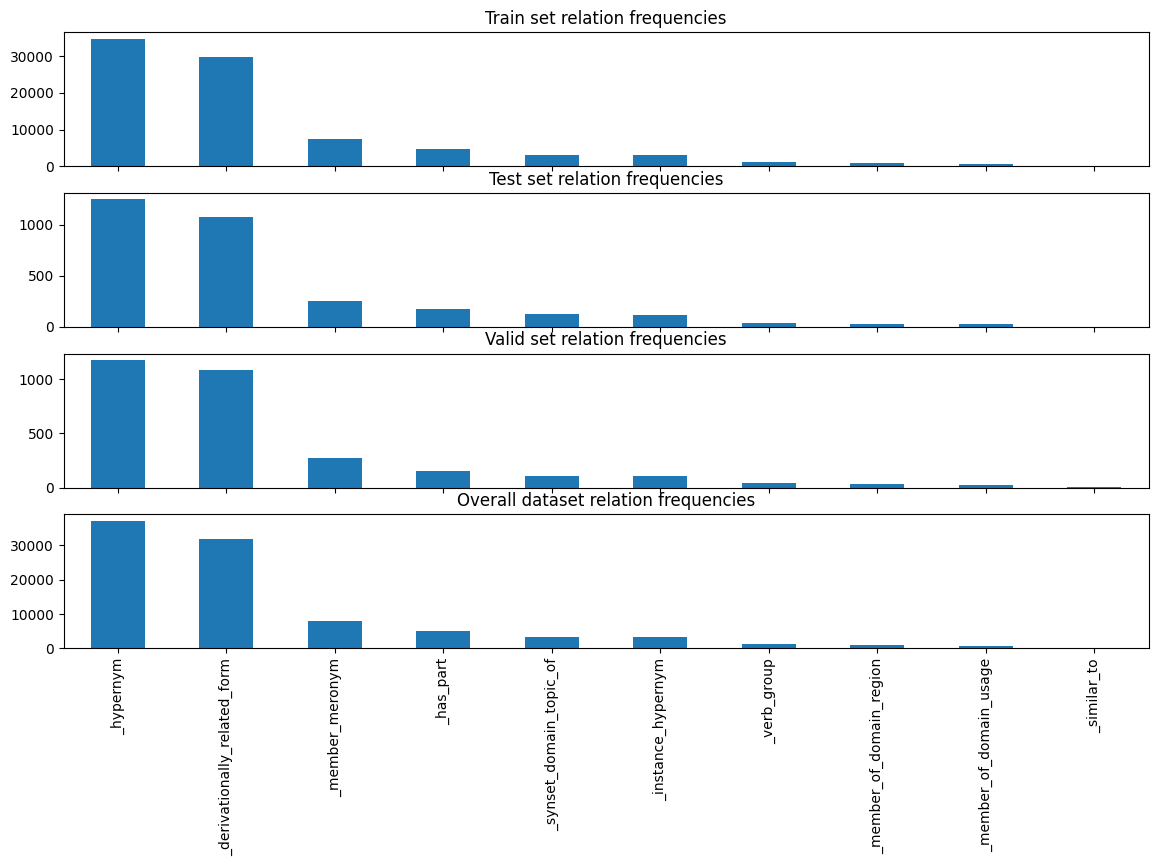

In [2]:
train, test, valid, definitions = DataReader.load_csv(config.raw_train, sep='\t', names=["head", "relation", "tail"]), \
                                  DataReader.load_csv(config.raw_test, sep='\t',  names=["head", "relation", "tail"]), \
                                  DataReader.load_csv(config.raw_valid, sep='\t', names=["head", "relation", "tail"]), \
                                  DataReader.load_csv(config.definition, sep='\t',  names=['entity_id', 'entity', 'definitions'])

id2name = definitions.set_index('entity_id').to_dict()['entity']

name2defs = definitions.set_index('entity').to_dict()['definitions']

train, test, valid = make_replacements(train, id2name, name2defs), \
                     make_replacements(test, id2name, name2defs), \
                     make_replacements(valid, id2name, name2defs)

wn18rr= pd.concat([train, test, valid], axis=0)


print(f"The size of train set is:{train.shape[0]}")
print(f"The size of test set is:{test.shape[0]}")
print(f"The size of valid set is:{valid.shape[0]}")
print(f"The size of overall dataseet is:{wn18rr.shape[0]}")
print(f"The size of the definitions are:{definitions.shape[0]}")
print(f"The size of relations is: {len(wn18rr['relation'].value_counts())}")
print("-"*50)

display(train.head(3))


fig, axs = plt.subplots(4, 1, figsize=(14,8), sharex=True)
train['relation'].value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title('Train set relation frequencies')

test['relation'].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Test set relation frequencies')

valid['relation'].value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title('Valid set relation frequencies')

wn18rr['relation'].value_counts().plot(ax=axs[3], kind='bar')
axs[3].set_title('Overall dataset relation frequencies')


## Plot stats for relations (the numbers reprsents bar plots in the diagram)

In [3]:
print("TRAIN:\n", train['relation'].value_counts(), end='\n\n')
print("TEST:\n",  test['relation'].value_counts(), end='\n\n')
print("VALID:\n", valid['relation'].value_counts(), end='\n\n')

TRAIN:
 _hypernym                       34796
_derivationally_related_form    29715
_member_meronym                  7402
_has_part                        4816
_synset_domain_topic_of          3116
_instance_hypernym               2921
_verb_group                      1138
_member_of_domain_region          923
_member_of_domain_usage           629
_similar_to                        80
Name: relation, dtype: int64

TEST:
 _hypernym                       1251
_derivationally_related_form    1074
_member_meronym                  253
_has_part                        172
_instance_hypernym               122
_synset_domain_topic_of          114
_verb_group                       39
_member_of_domain_region          26
_member_of_domain_usage           24
_similar_to                        3
Name: relation, dtype: int64

VALID:
 _hypernym                       1174
_derivationally_related_form    1078
_member_meronym                  273
_has_part                        154
_instance_hypernym 

# 2. Create entity detection dataset

In [4]:
def make_entity_detection_dataset(df, count, use_sampling = False):
    df = pd.concat([
            df[['head', "head-entity-type", "head-def"]].rename(columns={"head":"entity", "head-entity-type":"type", "head-def":"definition"}), 
            df[['tail', "tail-entity-type", "tail-def"]].rename(columns={"tail":"entity", "tail-entity-type":"type", "tail-def":"definition"})
            ]).reset_index(drop=True)
    
    # print(f"ENTITY DETECT: The size of new df is:{df.shape[0]}")
    df = df.drop_duplicates(subset=['entity', 'type'], keep='first')
    if use_sampling:
        dfs = []
        for type_name, type_df in df.groupby("type"):
            if type_df.shape[0] <= count:
                dfs.append(type_df)
            else:
                dfs.append(type_df.sample(count, random_state=222, replace=False))
        df = pd.concat(dfs)
        
        df = df.drop_duplicates(subset=['entity', 'type'], keep='first')
    # print(f"ENTITY DETECT: The size of new df after duplicate removals is:{df.shape[0]}")
    return df

The size of entity type detection train set is:40476
The size of entity type detection test set is:5232
The size of entity type detection valid set is:5110
The size of overall entity type detection dataseet is:50818
The size of entity type classes is: 4


Text(0.5, 1.0, 'Overall dataset entity types frequencies')

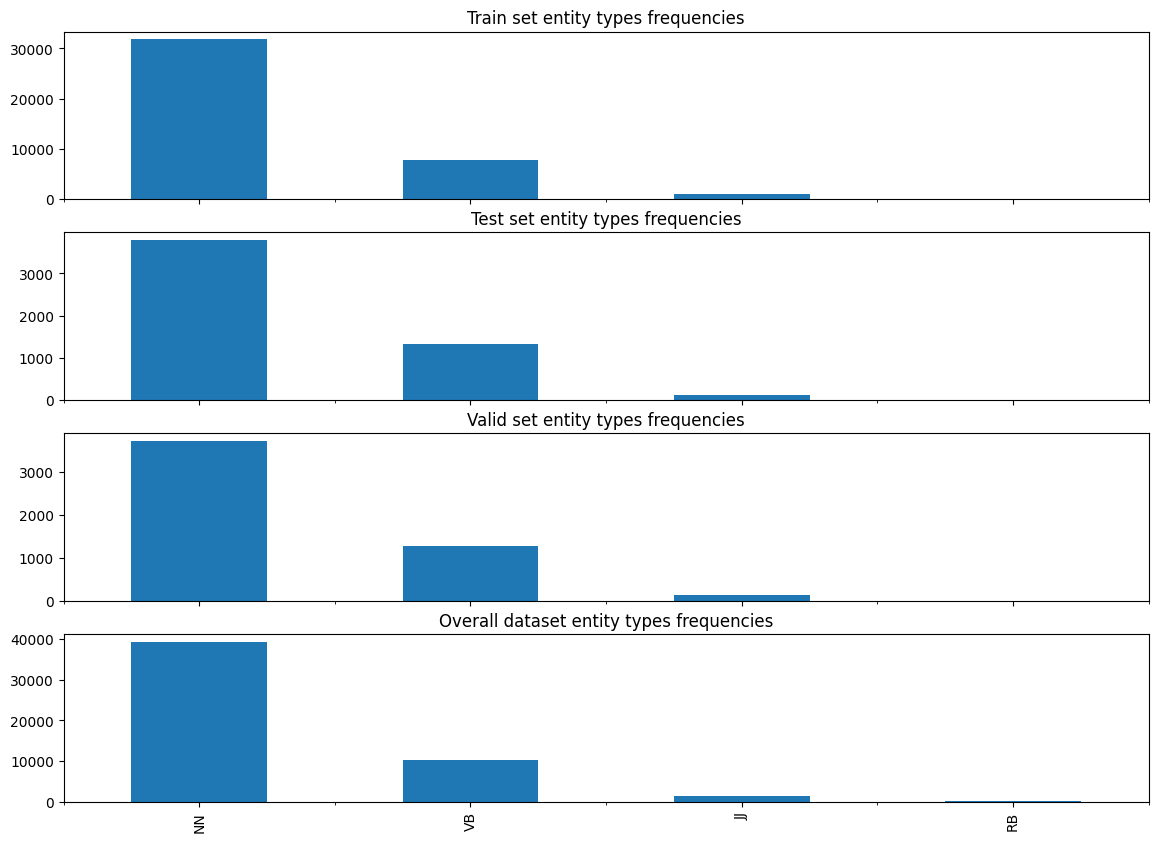

In [5]:
etrain, etest, evalid = make_entity_detection_dataset(train, count=10000), \
                           make_entity_detection_dataset(test, count=1000), \
                           make_entity_detection_dataset(valid, count=1000)
ewn18rr= pd.concat([etrain, etest, evalid], axis=0)


print(f"The size of entity type detection train set is:{etrain.shape[0]}")
print(f"The size of entity type detection test set is:{etest.shape[0]}")
print(f"The size of entity type detection valid set is:{evalid.shape[0]}")
print(f"The size of overall entity type detection dataseet is:{ewn18rr.shape[0]}")
print(f"The size of entity type classes is: {len(ewn18rr['type'].value_counts())}")

fig, axs = plt.subplots(4, 1, figsize=(14,10), sharex=True)
etrain['type'].value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title('Train set entity types frequencies')

etest['type'].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Test set entity types frequencies')

evalid['type'].value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title('Valid set entity types frequencies')

ewn18rr['type'].value_counts().plot(ax=axs[3], kind='bar')
axs[3].set_title('Overall dataset entity types frequencies')

## Plot stats for entity types (the numbers reprsents bar plots in the diagram)

In [6]:
print("TRAIN:\n", etrain['type'].value_counts(), end='\n\n')
print("TEST:\n", etest['type'].value_counts(), end='\n\n')
print("VALID:\n", evalid['type'].value_counts(), end='\n\n')

TRAIN:
 NN    31761
VB     7663
JJ     1023
RB       29
Name: type, dtype: int64

TEST:
 NN    3784
VB    1336
JJ     107
RB       5
Name: type, dtype: int64

VALID:
 NN    3709
VB    1276
JJ     122
RB       3
Name: type, dtype: int64



# 3. Now lets put cap on entity types for train,test and test sets and plot the stats

The size of entity type detection train set is:18715
The size of entity type detection test set is:5148
The size of entity type detection valid set is:5101
The size of overall entity type detection dataseet is:28964
The size of entity type classes is: 4


Text(0.5, 1.0, 'Overall dataset entity types frequencies')

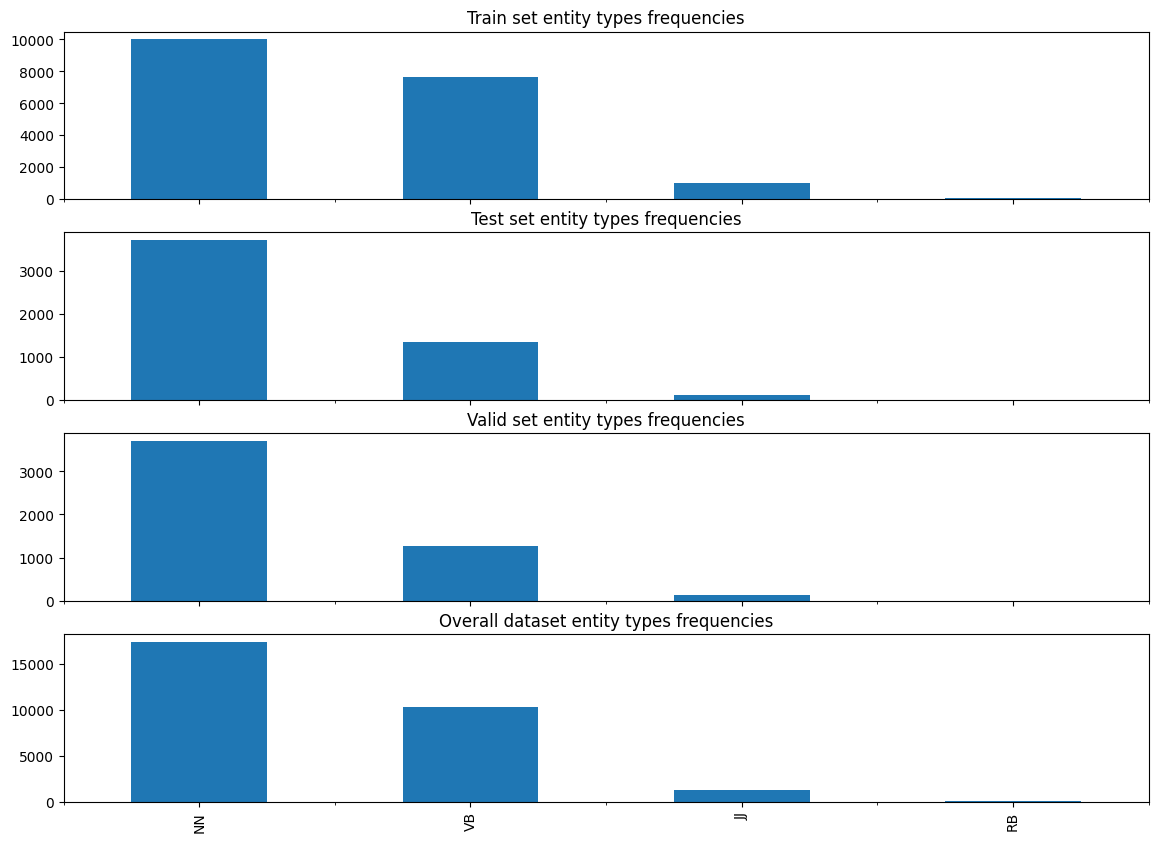

In [7]:
etrain, etest, evalid = make_entity_detection_dataset(train, count=10000, use_sampling=True), \
                           make_entity_detection_dataset(test, count=3700, use_sampling=True), \
                           make_entity_detection_dataset(valid, count=3700, use_sampling=True)
ewn18rr= pd.concat([etrain, etest, evalid], axis=0)


print(f"The size of entity type detection train set is:{etrain.shape[0]}")
print(f"The size of entity type detection test set is:{etest.shape[0]}")
print(f"The size of entity type detection valid set is:{evalid.shape[0]}")
print(f"The size of overall entity type detection dataseet is:{ewn18rr.shape[0]}")
print(f"The size of entity type classes is: {len(ewn18rr['type'].value_counts())}")

fig, axs = plt.subplots(4, 1, figsize=(14,10), sharex=True)
etrain['type'].value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title('Train set entity types frequencies')

etest['type'].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Test set entity types frequencies')

evalid['type'].value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title('Valid set entity types frequencies')

ewn18rr['type'].value_counts().plot(ax=axs[3], kind='bar')
axs[3].set_title('Overall dataset entity types frequencies')

In [8]:
print("TRAIN:\n", etrain['type'].value_counts(), end='\n\n')
print("TEST:\n", etest['type'].value_counts(), end='\n\n')
print("VALID:\n", evalid['type'].value_counts(), end='\n\n')

TRAIN:
 NN    10000
VB     7663
JJ     1023
RB       29
Name: type, dtype: int64

TEST:
 NN    3700
VB    1336
JJ     107
RB       5
Name: type, dtype: int64

VALID:
 NN    3700
VB    1276
JJ     122
RB       3
Name: type, dtype: int64



# 4. Considering new set of relation detection dataset based on obtained entities

new shapes are: (28330, 7) (22375, 7) (2971, 7) (2984, 7)


Text(0.5, 1.0, 'Overall dataset relation frequencies')

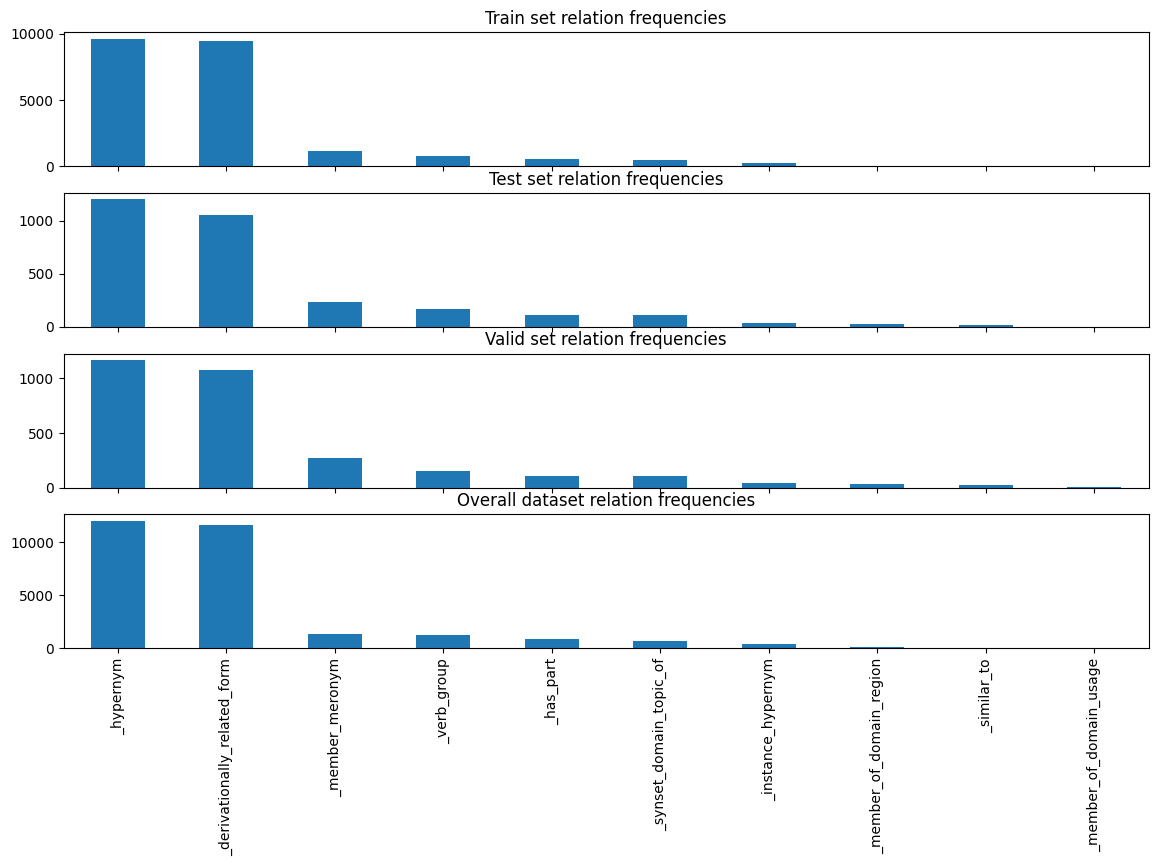

In [12]:
new_train = train[train['head'].isin(etrain['entity'].tolist()) & train['tail'].isin(etrain['entity'].tolist())] 
new_test = test[test['head'].isin(etest['entity'].tolist()) & test['tail'].isin(etest['entity'].tolist())] 
new_valid = valid[valid['head'].isin(evalid['entity'].tolist()) & valid['tail'].isin(evalid['entity'].tolist())] 

new_wn18rr= pd.concat([new_train, new_test, new_valid], axis=0)

print("new shapes are:", new_wn18rr.shape, new_train.shape, new_test.shape, new_valid.shape)

fig, axs = plt.subplots(4, 1, figsize=(14,8), sharex=True)
new_train['relation'].value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title('Train set relation frequencies')

new_test['relation'].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Test set relation frequencies')

new_valid['relation'].value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title('Valid set relation frequencies')

new_wn18rr['relation'].value_counts().plot(ax=axs[3], kind='bar')
axs[3].set_title('Overall dataset relation frequencies')

In [13]:
print("TRAIN:\n", new_train['relation'].value_counts(), end='\n\n')
print("TEST:\n", new_test['relation'].value_counts(), end='\n\n')
print("VALID:\n", new_valid['relation'].value_counts(), end='\n\n')

TRAIN:
 _hypernym                       9635
_derivationally_related_form    9446
_verb_group                     1132
_member_meronym                  799
_has_part                        540
_synset_domain_topic_of          501
_instance_hypernym               217
_similar_to                       52
_member_of_domain_region          43
_member_of_domain_usage           10
Name: relation, dtype: int64

TEST:
 _hypernym                       1203
_derivationally_related_form    1052
_member_meronym                  238
_has_part                        165
_synset_domain_topic_of          113
_instance_hypernym               110
_verb_group                       39
_member_of_domain_region          26
_member_of_domain_usage           22
_similar_to                        3
Name: relation, dtype: int64

VALID:
 _hypernym                       1169
_derivationally_related_form    1074
_member_meronym                  273
_has_part                        154
_instance_hypernym           